In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

from matplotlib import pyplot as plt

# Dataset

In [501]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

dataset_full = MNIST('data/', train = True, download = True, transform = transforms.ToTensor())
# idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]
normal_idx = torch.where((dataset_full.targets == 7))[0]
anomaly_idx = torch.where((dataset_full.targets == 1))[0]
idx = torch.cat([normal_idx, anomaly_idx[:512]])

x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)

tensor(7)


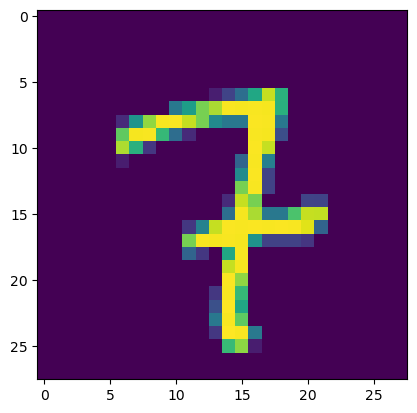

In [502]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

In [505]:
from Sparse.modules.variational import VariationalLayer
from Sparse.modules.variational.utils import SGVBL
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from torch import nn
class VariationalEncoder(nn.Linear, nn.Module):
    def __init__(self, in_features, out_features, bias=True) -> None:
        super(VariationalEncoder, self).__init__(in_features, out_features, bias)
        self.log_sigma_weight = Parameter(torch.Tensor(out_features, in_features))

        torch.nn.init.xavier_uniform_(self.log_sigma_weight)
        # self.log_sigma_weight.data.fill_(-5)
        self.mu, self.sigma = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu = F.linear(x, self.weight, self.bias)
        sigma = torch.exp(F.linear(x, self.log_sigma_weight))

        if self.training:
            self.mu, self.sigma = mu, sigma

        # Reparameterization trick
        eps = torch.normal(0, torch.ones_like(sigma))
        return mu + sigma * eps

    def kl_reg(self):
        # KL-Divergence regularization $D_{KL}(\mathcal{N}(;\mu_\theta, \sigma_\theta) | \mathcal{N}(;\0, I))$
        # More details in https://arxiv.org/abs/1312.6114.
        return .5 * (self.mu**2 + self.sigma**2 - torch.log(self.sigma**2) - 1).sum()

In [506]:
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_size, latent_space):
        super(VAE, self).__init__()
        conv_out_size = input_size // (2*2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(12*(conv_out_size**2), 128),
            nn.Dropout(0.5),
            nn.ReLU(),
        )

        self.botleneck = VariationalEncoder(128, latent_space)

        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 12*(conv_out_size**2)),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Unflatten(1, (12, conv_out_size, conv_out_size)),
            nn.Conv2d(12, 8, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 1, 3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.botleneck(x)
        x = self.decoder(x)
        return x

model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), loss=mse_loss)

In [507]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100
from tqdm import tqdm
kl_weight = 0.02

opt = torch.optim.Adam(model.parameters())
for epoch in tqdm(range(n_epochs)):
    kl_weight = min(kl_weight+0.01, 1)
    for x, y in train_loader:
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = sgvbl(x, x_hat, kl_weight)
        loss.backward()
        opt.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [517]:

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.botleneck(autoencoder.encoder(x.to(device)))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

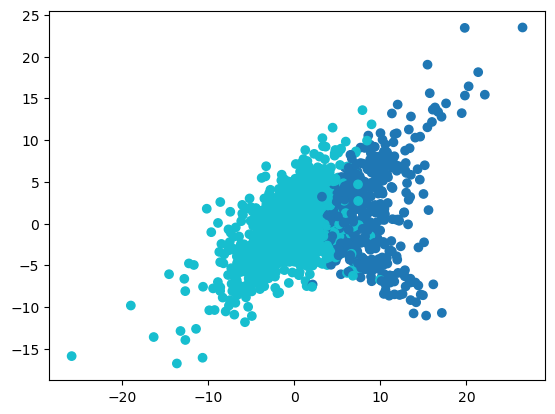

In [526]:
# model.eval()
model.train()
plot_latent(model, train_loader, num_batches=100)

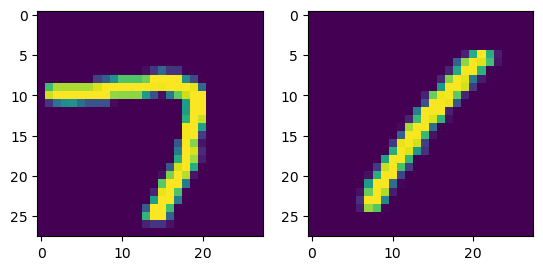

In [545]:
x, y = next(iter(train_loader))
x_0 = x[torch.argwhere(y==7).squeeze()[0]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1).squeeze()[0]].unsqueeze(0)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
model.train()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.botleneck(model.encoder(x_0.to(device))).detach().cpu())
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

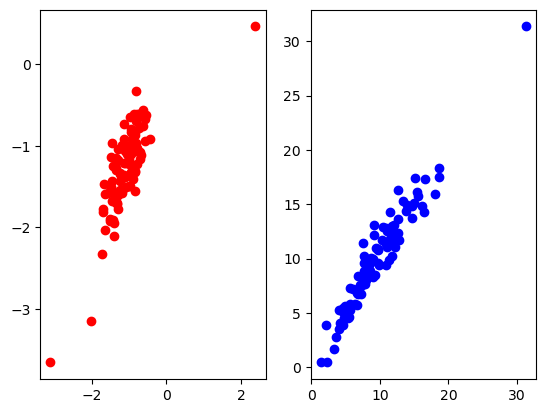

In [546]:
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

In [551]:
model.botleneck.mu

tensor([[3.2812, 1.6183]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [520]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-40, 10), r1=(-20, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

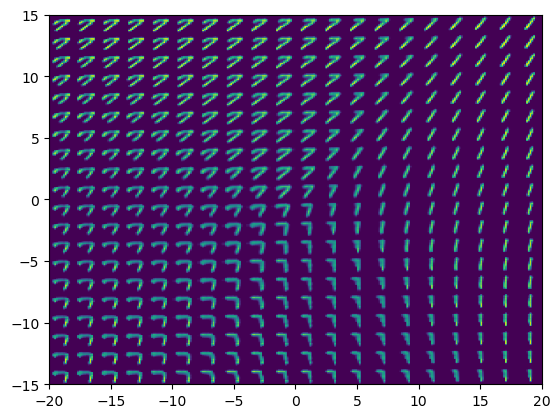

In [556]:
model.eval()
plot_reconstructed(model, r0=(-20, 20), r1=(-15, 15), n=20)

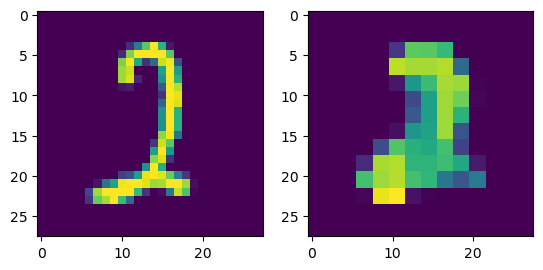

In [496]:
x = next(iter(train_loader))[0]
plt.subplot(1,2,1)
plt.imshow(x[0,0])

plt.subplot(1,2,2)
plt.imshow(model(x.cuda()).detach().cpu()[0,0])